Загрузка данных

In [626]:
from alpaca.data.timeframe import TimeFrame
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
import datetime

API_KEY = "PK1W6UGQYV6DJYD9HEP7"
SECRET_KEY = "ndH61mpUAGkK7jNKM8fgl1EvjUQKf0yDofyYP0pe"

client = CryptoHistoricalDataClient()
request_params = CryptoBarsRequest(
  symbol_or_symbols=["BTC/USD", 'ETH/USD', 'USDT/USD', 'XRP/USD', 'SOL/USD', 'USDC/USD', 'DOGE/USD', 'BCH/USD', 'LINK/USD', 'AVAX/USD'],
  timeframe=TimeFrame.Day,
  start=datetime.datetime(2020, 7, 1),
  end=datetime.datetime(2025, 7, 1)
)

btc_bars = client.get_crypto_bars(request_params)

df = btc_bars.df

df = df.sort_index(level=["symbol", "timestamp"])

Вспомогательные функции

In [627]:
import numpy as np
import pandas as pd

def show_nan(df: pd.DataFrame) -> pd.DataFrame:
    """Вернёт все строки, в которых есть хотя бы одно NaN."""
    mask = df.isna().any(axis=1)
    return df[mask]

def show_inf(df: pd.DataFrame) -> pd.DataFrame:
    """Вернёт все строки, в которых есть ±inf."""
    mask = np.isinf(df).any(axis=1)
    return df[mask]


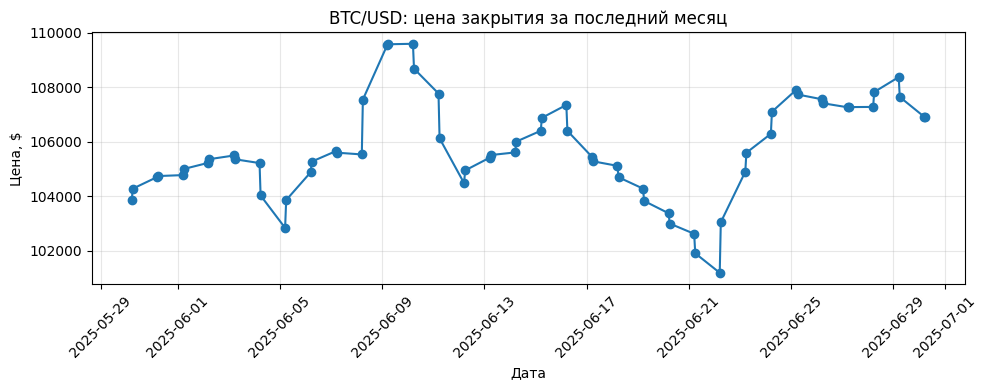

In [541]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Данные только для биткоина
btc = df.xs('BTC/USD', level='symbol').sort_index()

# 2. Последний день и стартовый день (‑1 календарный месяц)
last_date  = btc.index.max()                         # например, 2025‑07‑01 00:00:00+00:00
start_date = (last_date - pd.DateOffset(months=1)).normalize()

# 3. Срез за нужный интервал
btc_month = btc.loc[start_date:last_date]

# 4. График
plt.figure(figsize=(10, 4))
plt.plot(btc_month.index, btc_month['close'], marker='o')
plt.title('BTC/USD: цена закрытия за последний месяц')
plt.xlabel('Дата')
plt.ylabel('Цена, $')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# (необязательно) сохранить картинку
# plt.savefig('btc_last_month.png', dpi=300)


Добавление меток о сезоне и дне недели

In [628]:
import pandas as pd

ts = df.index.get_level_values('timestamp')
ts = pd.to_datetime(ts)

dow_dummies = pd.get_dummies(ts.day_name(), prefix='is', dtype=bool).reindex(
    columns=['is_Monday', 'is_Tuesday', 'is_Wednesday', 'is_Thursday',
             'is_Friday', 'is_Saturday', 'is_Sunday'], fill_value=False)

def season(month):
    if month in (12, 1, 2):
        return 'winter'
    elif month in (3, 4, 5):
        return 'spring'
    elif month in (6, 7, 8):
        return 'summer'
    else:
        return 'autumn'

season_dummies = pd.get_dummies([season(m) for m in ts.month], prefix='is', dtype=bool).reindex(
    columns=['is_winter', 'is_spring', 'is_summer', 'is_autumn'], fill_value=False)

dow_dummies.index = df.index
season_dummies.index = df.index

df = df.join(dow_dummies).join(season_dummies)

Добавление индекса страха и жадности

In [629]:
import requests

def get_fear_greed_data():
    url = "https://api.alternative.me/fng/?limit=0&format=json"
    response = requests.get(url)
    data = response.json()['data']
    df = pd.DataFrame(data)
    df['timestamp'] = pd.to_datetime(df['timestamp'].astype(int), unit='s').dt.date
    df['fear&greed'] = df['value'].astype(int)
    return df[['timestamp', 'fear&greed']]

fng_df = get_fear_greed_data()

df = df.reset_index()
df['date'] = df['timestamp'].dt.date

df = df.merge(fng_df, how='left', left_on='date', right_on='timestamp')

df = df.drop(columns=['timestamp_y', 'date'])
df = df.rename(columns={'timestamp_x': 'timestamp'})

df = df.set_index(['symbol', 'timestamp'])

Подготовка к предобработке

In [630]:
import numpy as np

TRAIN_END = pd.Timestamp("2024-12-31", tz="UTC")
VAL_END   = pd.Timestamp("2025-04-30", tz="UTC")

FEATURE_COLS = [
    "open", "high", "low", "close", "volume",
    "trade_count", "vwap", "fear&greed"
]

Заполнение пропуска (NaN)

In [631]:
show_nan(df)

,,open,high,low,close,volume,trade_count,vwap,is_Monday,is_Tuesday,is_Wednesday,is_Thursday,is_Friday,is_Saturday,is_Sunday,is_winter,is_spring,is_summer,is_autumn,fear&greed
symbol,timestamp,,,,,,,,,,,,,,,,,,,
AVAX/USD,2024-10-26 05:00:00+00:00,25.286250,25.651300,24.882450,25.547250,250.496270,13.0,25.152669,False,False,False,False,False,True,False,False,False,False,True,NaN
BCH/USD,2024-10-26 05:00:00+00:00,353.250000,356.705000,345.712500,350.150000,0.043874,4.0,352.036053,False,False,False,False,False,True,False,False,False,False,True,NaN
BTC/USD,2024-10-26 05:00:00+00:00,66861.089000,67371.350000,66678.000000,67097.760000,0.177576,47.0,66953.545086,False,False,False,False,False,True,False,False,False,False,True,NaN
DOGE/USD,2024-10-26 05:00:00+00:00,0.133717,0.138476,0.131975,0.138050,73541.034621,33.0,0.136211,False,False,False,False,False,True,False,False,False,False,True,NaN
ETH/USD,2024-10-26 05:00:00+00:00,2458.190000,2503.540000,2439.495000,2478.335000,4.701217,28.0,2465.945268,False,False,False,False,False,True,False,False,False,False,True,NaN
LINK/USD,2024-10-26 05:00:00+00:00,11.281250,11.373000,10.808900,10.977900,98.903688,21.0,11.040806,False,False,False,False,False,True,False,False,False,False,True,NaN
SOL/USD,2024-10-26 05:00:00+00:00,166.169000,172.975000,166.061000,172.334000,141.586934,16.0,172.371872,False,False,False,False,False,True,False,False,False,False,True,NaN
USDC/USD,2024-10-26 05:00:00+00:00,0.999819,1.001110,0.998900,1.000009,4439.921610,7.0,1.000898,False,False,False,False,False,True,False,False,False,False,True,NaN
USDT/USD,2024-10-26 05:00:00+00:00,0.998641,1.000000,0.997930,0.998595,3711.655687,5.0,0.998346,False,False,False,False,False,True,False,False,False,False,True,NaN


In [632]:
date_to_fix = pd.Timestamp('2024-10-26', tz='UTC')
ts_index = df.index.get_level_values('timestamp').normalize()
mask_date = ts_index == date_to_fix
df.loc[mask_date, 'fear&greed'] = df.loc[mask_date, 'fear&greed'].fillna(50)
show_nan(df)

,,open,high,low,close,volume,trade_count,vwap,is_Monday,is_Tuesday,is_Wednesday,is_Thursday,is_Friday,is_Saturday,is_Sunday,is_winter,is_spring,is_summer,is_autumn,fear&greed
symbol,timestamp,,,,,,,,,,,,,,,,,,,


Заполнение нулей в количественных признаках 

In [633]:
import numpy as np
import pandas as pd

def fill_zeros_with_prev(df: pd.DataFrame,
                         feature_cols: list[str],
                         symbol_level: str = "symbol") -> pd.DataFrame:
    out = df.copy()

    # 1. Нули -> NaN (только в интересующих столбцах)
    out[feature_cols] = out[feature_cols].where(out[feature_cols] != 0, np.nan)

    # 2. Заполняем NaN предыдущим значением внутри каждой группы символов
    if symbol_level in out.index.names:
        out[feature_cols] = (
            out.groupby(level=symbol_level)[feature_cols].ffill()
        )
    else:  # обычный индекс
        out[feature_cols] = out[feature_cols].ffill()

    return out

df = fill_zeros_with_prev(df, FEATURE_COLS)


In [634]:
show_nan(df)

,,open,high,low,close,volume,trade_count,vwap,is_Monday,is_Tuesday,is_Wednesday,is_Thursday,is_Friday,is_Saturday,is_Sunday,is_winter,is_spring,is_summer,is_autumn,fear&greed
symbol,timestamp,,,,,,,,,,,,,,,,,,,


Заполнение пропусков в временных рядах

In [635]:
import pandas as pd
from typing import List


def fill_missing_between_bounds(
    df: pd.DataFrame,
    feature_cols: List[str],
    *,
    interp_method: str = "linear",
) -> pd.DataFrame:
    """
    Заполняет пропущенные дни (строки) между первой и последней датой для каждого symbol,
    а также интерполирует NaN в существующих строках по feature_cols.
    Не трогает существующие заполненные значения.
    """

    if list(df.index.names) != ["symbol", "timestamp"]:
        raise ValueError("df must have a MultiIndex with levels ['symbol', 'timestamp'].")

    filled_parts = []

    for symbol, grp in df.groupby(level="symbol", sort=True):
        grp = grp.sort_index(level="timestamp")
        ts = grp.index.get_level_values("timestamp")
        start, end = ts.min(), ts.max()

        # Время суток первой записи (например, 05:00)
        t0 = start.time()

        # Создаём полный индекс дней с тем же временем суток
        full_dates = (
            pd.date_range(start=start.normalize(), end=end.normalize(), freq="D", tz=start.tz)
            + pd.Timedelta(hours=t0.hour, minutes=t0.minute)
        )

        # MultiIndex со всеми датами для данного символа
        full_index = pd.MultiIndex.from_product([[symbol], full_dates], names=["symbol", "timestamp"])

        # Объединяем с существующим индексом, чтобы не потерять существующие даты
        new_index = full_index.union(grp.index)

        # Переиндексация — тут появятся NaN для новых дат
        temp = grp.reindex(new_index)

        # Интерполируем NaN (в новых и старых строках)
        temp_interp = temp[feature_cols].interpolate(
            method=interp_method,
            limit_direction="both",
            limit_area="inside",
        )

        # Заполняем пропуски интерполяцией (оставляя уже заполненные значения без изменений)
        temp[feature_cols] = temp[feature_cols].fillna(temp_interp)

        # Для нечисловых колонок — forward fill
        other_cols = temp.columns.difference(feature_cols)
        if len(other_cols):
            temp[other_cols] = temp[other_cols].fillna(method="ffill")

        filled_parts.append(temp)

    return pd.concat(filled_parts).sort_index()




In [636]:
df_filled = fill_missing_between_bounds(df, FEATURE_COLS)
df = df_filled

C:\Users\haypr\AppData\Local\Temp\ipykernel_5148\2675511459.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp[other_cols] = temp[other_cols].fillna(method="ffill")
C:\Users\haypr\AppData\Local\Temp\ipykernel_5148\2675511459.py:58: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  temp[other_cols] = temp[other_cols].fillna(method="ffill")
C:\Users\haypr\AppData\Local\Temp\ipykernel_5148\2675511459.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  temp[other_cols] = temp[other_cols].fillna(method="ffill")
C:\Users\haypr\AppData\Local\Temp\ipykernel_5148\2675511459.py:58: FutureWarning

In [637]:
show_nan(df)

,,open,high,low,close,volume,trade_count,vwap,is_Monday,is_Tuesday,is_Wednesday,is_Thursday,is_Friday,is_Saturday,is_Sunday,is_winter,is_spring,is_summer,is_autumn,fear&greed
symbol,timestamp,,,,,,,,,,,,,,,,,,,
AVAX/USD,2025-06-30 06:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,False,False,True,False,NaN
BCH/USD,2025-06-30 06:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,False,False,True,False,NaN
BTC/USD,2025-06-30 06:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,False,False,True,False,NaN
DOGE/USD,2025-06-30 06:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,False,False,True,False,NaN
ETH/USD,2025-06-30 06:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,False,False,True,False,NaN
LINK/USD,2025-06-30 06:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,False,False,True,False,NaN
SOL/USD,2025-06-30 06:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,False,False,True,False,NaN
USDT/USD,2025-06-30 06:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,False,False,True,False,NaN
XRP/USD,2025-06-30 06:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False,False,False,False,False,False,False,True,False,NaN


In [638]:
import pandas as pd

fill_timestamp = pd.Timestamp('2025-06-30 06:00:00+00:00')
feature_cols = ['close', 'open', 'high', 'low', 'volume', 'trade_count', 'vwap', 'fear&greed']

# Функция для заполнения NaN по конкретному timestamp для всех symbols
def fill_nan_for_timestamp_linear(df, ts, cols):
    # Найдём все символы, у которых есть данный timestamp (или нет)
    symbols = df.index.get_level_values('symbol').unique()

    for symbol in symbols:
        # Отфильтруем данные по символу
        df_sym = df.xs(symbol, level='symbol')

        # Проверим, есть ли пропуски в ts
        if ts in df_sym.index and df_sym.loc[ts, cols].isna().any():
            # Сделаем интерполяцию по всему временному ряду для этого symbol
            interp = df_sym[cols].interpolate(method='linear', limit_direction='both')

            # Заменим только пропущенные значения для этого timestamp
            for col in cols:
                if pd.isna(df.loc[(symbol, ts), col]):
                    df.loc[(symbol, ts), col] = interp.loc[ts, col]

    return df

# Вызов функции
df = fill_nan_for_timestamp_linear(df, fill_timestamp, feature_cols)



In [639]:
show_nan(df)

,,open,high,low,close,volume,trade_count,vwap,is_Monday,is_Tuesday,is_Wednesday,is_Thursday,is_Friday,is_Saturday,is_Sunday,is_winter,is_spring,is_summer,is_autumn,fear&greed
symbol,timestamp,,,,,,,,,,,,,,,,,,,


In [640]:
show_inf(df)

,,open,high,low,close,volume,trade_count,vwap,is_Monday,is_Tuesday,is_Wednesday,is_Thursday,is_Friday,is_Saturday,is_Sunday,is_winter,is_spring,is_summer,is_autumn,fear&greed
symbol,timestamp,,,,,,,,,,,,,,,,,,,


Обрабатываем выбросы логарифмированием

In [641]:
shift = 1e-8               # например, 10‑8
df[FEATURE_COLS] = np.log(df[FEATURE_COLS] + shift)

In [642]:
show_nan(df)

,,open,high,low,close,volume,trade_count,vwap,is_Monday,is_Tuesday,is_Wednesday,is_Thursday,is_Friday,is_Saturday,is_Sunday,is_winter,is_spring,is_summer,is_autumn,fear&greed
symbol,timestamp,,,,,,,,,,,,,,,,,,,


Делим выборку и масштабируем количественные признаки

In [655]:
from sklearn.preprocessing import StandardScaler



idx_ts = df.index.get_level_values("timestamp")

train = df[idx_ts <= TRAIN_END]
val   = df[(idx_ts > TRAIN_END) & (idx_ts <= VAL_END)]
test  = df[idx_ts > VAL_END]
    
train_log = df[idx_ts <= TRAIN_END]
val_log   = df[(idx_ts > TRAIN_END) & (idx_ts <= VAL_END)]
test_log  = df[idx_ts > VAL_END]

feature_scalers = {}
train_scaled_list = []
val_scaled_list   = []
test_scaled_list  = []
target_scalers = {}

for sym, g_train in train_log.groupby(level="symbol"):
    # Масштабируем признаки без 'close'
    sc_feat = StandardScaler()
    sc_feat.fit(g_train[FEATURE_COLS])  # FEATURE_COLS без 'close'
    feature_scalers[sym] = sc_feat

    # Масштабируем отдельно таргет 'close'
    sc_targ = StandardScaler()
    sc_targ.fit(g_train[['close']])
    target_scalers[sym] = sc_targ

    def scale_split(split_df):
        g = split_df.xs(sym, level="symbol", drop_level=False).copy()
        g[FEATURE_COLS] = sc_feat.transform(g[FEATURE_COLS])
        g['close'] = sc_targ.transform(g[['close']])
        return g

    train_scaled_list.append(scale_split(train_log))
    val_scaled_list.append(scale_split(val_log))
    test_scaled_list.append(scale_split(test_log))


train_scaled = pd.concat(train_scaled_list).sort_index()
val_scaled   = pd.concat(val_scaled_list).sort_index()
test_scaled  = pd.concat(test_scaled_list).sort_index()


In [644]:
idx_ts = df.index.get_level_values("timestamp")


In [665]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

TIME_STEPS = 30
HORIZON = 1  # Прогнозируем 1 день вперёд
BATCH_SIZE = 16
EPOCHS = 50

FEATURE_COLS = [col for col in train_scaled.columns if col != "close"]
TARGET_COL = "close"

symbols = train_scaled.index.get_level_values("symbol").unique()

def create_sequences(data, symbol, feature_cols, target_col, time_steps, horizon):
    df_sym = data.xs(symbol, level="symbol")
    X, y = [], []
    X_values = df_sym[feature_cols].values.astype(np.float32)
    y_values = df_sym[target_col].values.astype(np.float32)
    for i in range(len(df_sym) - time_steps - horizon + 1):
        X.append(X_values[i : i + time_steps])
        target_idx = i + time_steps + horizon - 1
        y.append(y_values[target_idx])
    return np.array(X), np.array(y)

def stack_split(data):
    X_all, y_all = [], []
    for sym in symbols:
        X_sym, y_sym = create_sequences(data, sym, FEATURE_COLS, TARGET_COL, TIME_STEPS, HORIZON)
        X_all.append(X_sym)
        y_all.append(y_sym)
    return np.concatenate(X_all), np.concatenate(y_all)

X_train, y_train = stack_split(train_scaled)
X_val, y_val = stack_split(val_scaled)

n_features = len(FEATURE_COLS)
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(TIME_STEPS, n_features), dropout=0.2, recurrent_dropout=0.2),
    LSTM(32, dropout=0.2, recurrent_dropout=0.2),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[es],
    verbose=2
)


Epoch 1/50


c:\Users\haypr\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1215/1215 - 24s - 20ms/step - loss: 0.1894 - mae: 0.2492 - val_loss: 0.2528 - val_mae: 0.3032
Epoch 2/50
1215/1215 - 19s - 15ms/step - loss: 0.1452 - mae: 0.2023 - val_loss: 0.2060 - val_mae: 0.2659
Epoch 3/50
1215/1215 - 19s - 15ms/step - loss: 0.1285 - mae: 0.1844 - val_loss: 0.1955 - val_mae: 0.2564
Epoch 4/50
1215/1215 - 20s - 16ms/step - loss: 0.1211 - mae: 0.1770 - val_loss: 0.2626 - val_mae: 0.2918
Epoch 5/50
1215/1215 - 20s - 16ms/step - loss: 0.1113 - mae: 0.1703 - val_loss: 0.2218 - val_mae: 0.2739
Epoch 6/50
1215/1215 - 19s - 16ms/step - loss: 0.1003 - mae: 0.1656 - val_loss: 0.1402 - val_mae: 0.2249
Epoch 7/50
1215/1215 - 20s - 16ms/step - loss: 0.0929 - mae: 0.1636 - val_loss: 0.2368 - val_mae: 0.2819
Epoch 8/50
1215/1215 - 19s - 16ms/step - loss: 0.0980 - mae: 0.1610 - val_loss: 0.2051 - val_mae: 0.2606
Epoch 9/50
1215/1215 - 20s - 16ms/step - loss: 0.0855 - mae: 0.1554 - val_loss: 0.2195 - val_mae: 0.2716
Epoch 10/50
1215/1215 - 20s - 17ms/step - loss: 0.0804 - mae: 0.15

In [617]:
def invert_scale_close(y_scaled, scaler, feature_idx):

    mean = scaler.mean_[feature_idx]
    scale = scaler.scale_[feature_idx]
    
    log_price = y_scaled * scale + mean
    price = np.exp(log_price)
    
    return price


In [667]:
import numpy as np
from sklearn.metrics import mean_squared_error

FEATURE_COLS = [col for col in test_scaled.columns if col != "close"]
TARGET_COL = "close"
TIME_STEPS = 30
HORIZON = 7  # Итеративный прогноз на неделю (7 дней)

symbols = test_scaled.index.get_level_values("symbol").unique()

def create_sequences_with_dates(data, symbol, feature_cols, target_col, time_steps):
    df_sym = data.xs(symbol, level="symbol")
    X, y, dates = [], [], []
    X_values = df_sym[feature_cols].values.astype(np.float32)
    y_values = df_sym[target_col].values.astype(np.float32)
    idx = df_sym.index
    for i in range(len(df_sym) - time_steps):
        X.append(X_values[i : i + time_steps])
        y.append(y_values[i + time_steps])  # таргет — следующий день после окна
        dates.append(idx[i + time_steps])
    return np.array(X), np.array(y), np.array(dates)

X_test_list, y_test_list, dates_list, symbols_list = [], [], [], []

for sym in symbols:
    X_s, y_s, d_s = create_sequences_with_dates(test_scaled, sym, FEATURE_COLS, TARGET_COL, TIME_STEPS)
    X_test_list.append(X_s)
    y_test_list.append(y_s)
    dates_list.append(d_s)
    symbols_list.extend([sym] * len(y_s))

X_test = np.concatenate(X_test_list)
y_test = np.concatenate(y_test_list)
dates_test = np.concatenate(dates_list)
symbols_test = np.array(symbols_list)

def iterative_forecast(model, X_start, steps, feature_cols, target_col, feature_scalers, symbol):
    X_pred = X_start.copy()
    preds = []
    sc_feat = feature_scalers[symbol]
    close_idx = feature_cols.index(target_col)

    for _ in range(steps):
        yhat = model.predict(X_pred[np.newaxis, :, :])[0, 0]
        preds.append(yhat)

        X_pred = np.roll(X_pred, shift=-1, axis=0)
        X_pred[-1, close_idx] = yhat

    return np.array(preds)

# Пример для одного символа и одного стартового окна
symbol = "BTC/USD"
scaler_feat = feature_scalers[symbol]
scaler_targ = target_scalers[symbol]

df_sym = test_scaled.xs(symbol, level="symbol")
X_values = df_sym[FEATURE_COLS].values.astype(np.float32)

start_idx = 0  # можно менять, чтобы выбрать стартовое окно
X_start = X_values[start_idx : start_idx + TIME_STEPS]

preds_scaled = iterative_forecast(
    model, X_start, steps=HORIZON,
    feature_cols=FEATURE_COLS,
    target_col=TARGET_COL,
    feature_scalers=feature_scalers,
    symbol=symbol
)

preds = np.exp(scaler_targ.inverse_transform(preds_scaled.reshape(-1,1)).ravel())
print(f"Прогноз на {HORIZON} дней для {symbol}:")
print(preds)


ValueError: 'close' is not in list

In [ ]:
def inv_transform(arr, scaler):
    # Обратное преобразование и exp (если логарифмирование делалось)
    return np.exp(scaler.inverse_transform(arr.reshape(-1, 1)).ravel())

def plot_symbol_predictions(symbol, symbols_array, dates_array, y_true_scaled, y_pred_scaled, feature_scalers):
    mask = symbols_array == symbol
    dates = pd.to_datetime(dates_array[mask])
    scaler = feature_scalers[symbol]
    y_true = inv_transform(y_true_scaled[mask], scaler)
    y_pred = inv_transform(y_pred_scaled[mask], scaler)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(14,6))
    plt.plot(dates, y_true, label="Actual price")
    plt.plot(dates, y_pred, label="Predicted price")
    plt.title(f"{symbol} — Actual vs Predicted Close Price (+{HORIZON} days)")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Вызов
plot_symbol_predictions(
    symbol="BTC/USD",
    symbols_array=symbols_test,
    dates_array=dates_test,
    y_true_scaled=y_test,
    y_pred_scaled=y_pred,
    feature_scalers=feature_scalers
)


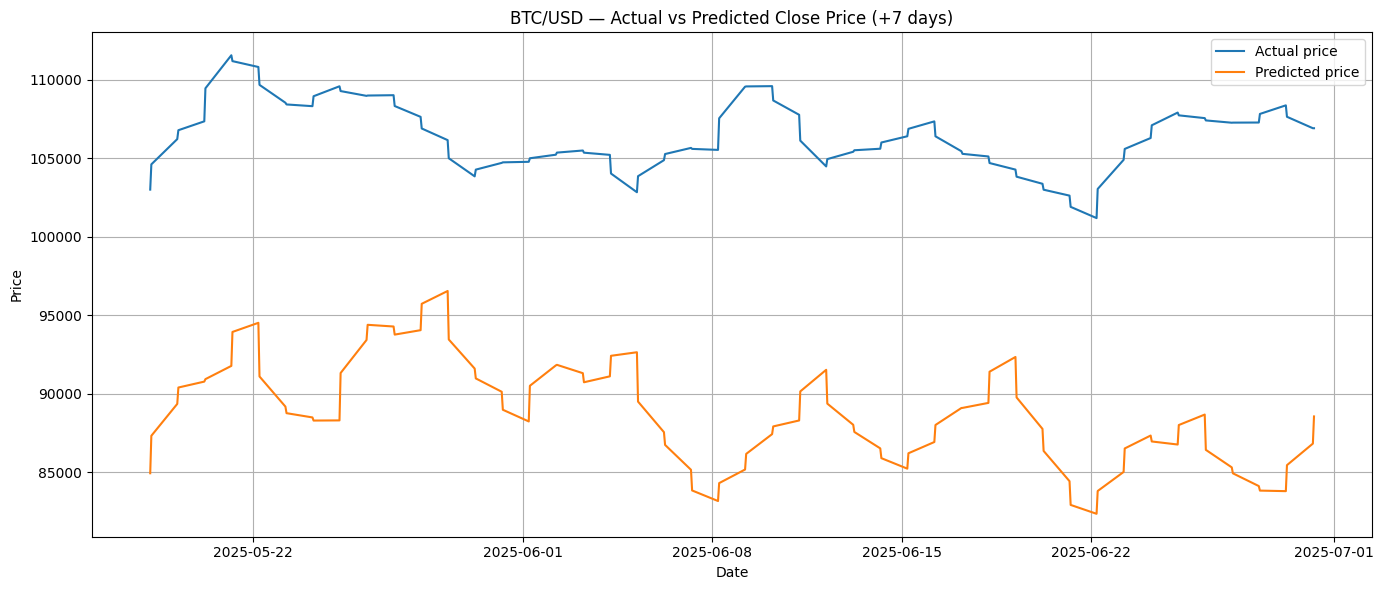

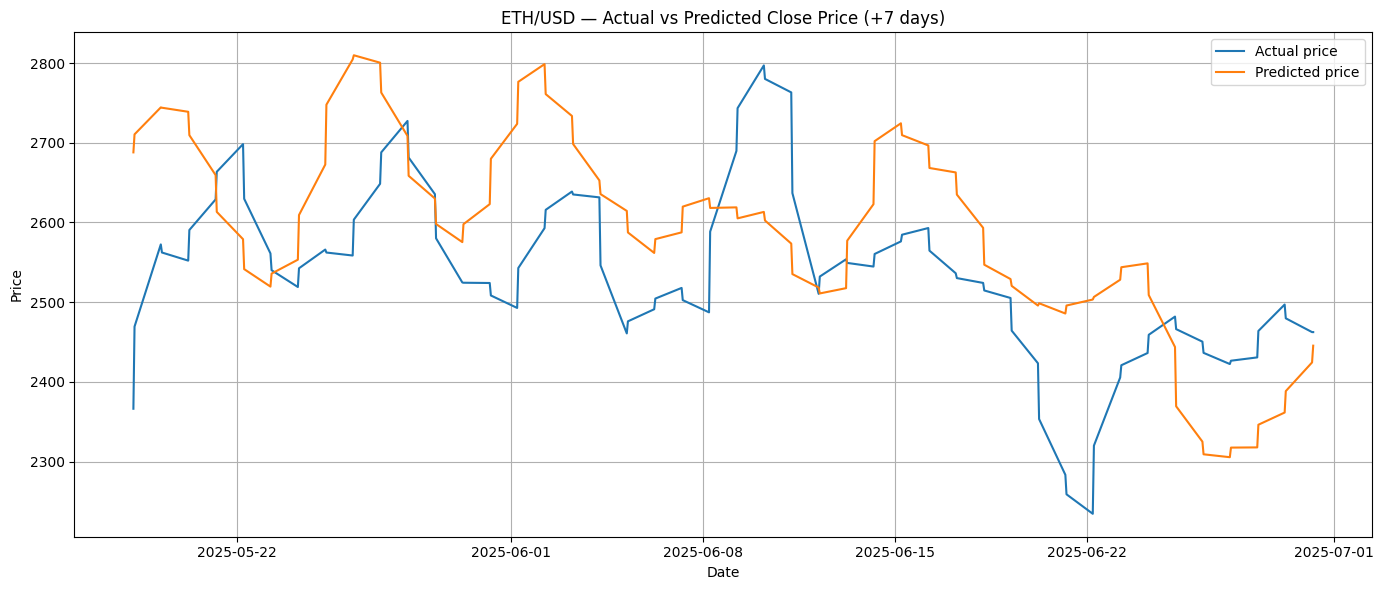

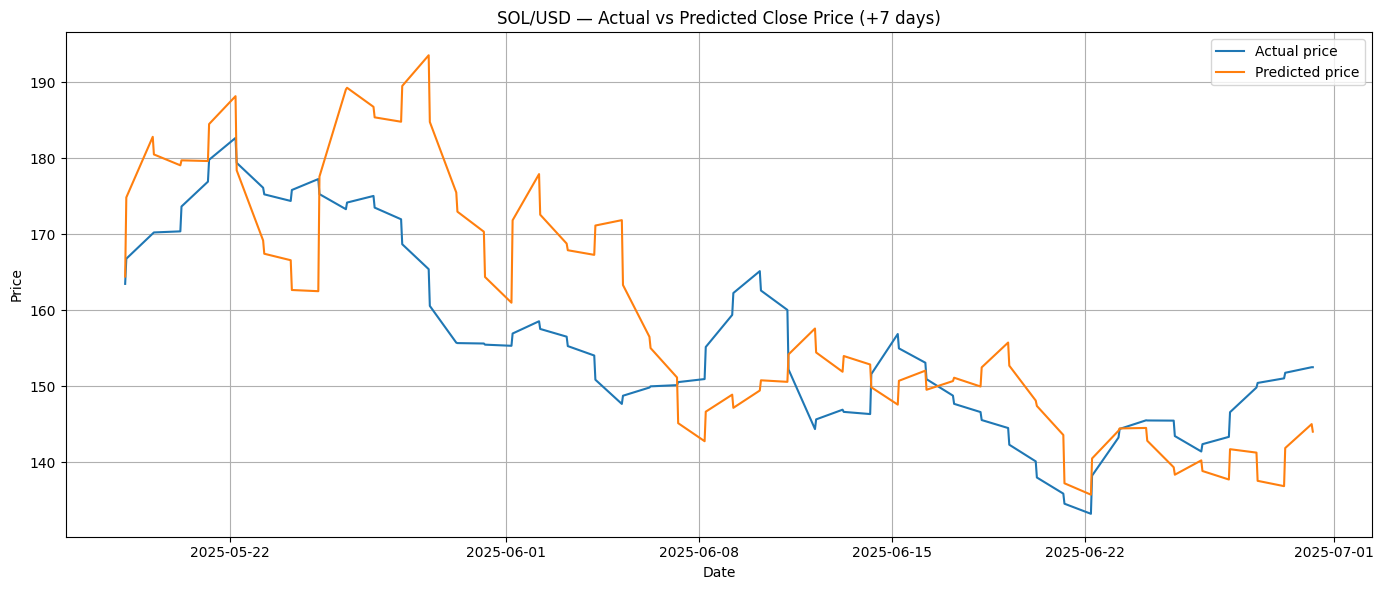

In [ ]:
plot_symbol_predictions(
    symbol="BTC",
    symbols_array=symbols_test,
    dates_array=dates_test,
    y_true_scaled=y_test,
    y_pred_scaled=y_pred,
    feature_scalers=feature_scalers,
    target_scalers=target_scalers
)
